<a href="https://colab.research.google.com/github/RaffaNimir/Match-Up-recruiter-/blob/main/(3)_Match_Up_Recruiter_doc2vec_doc2ve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Getting** the user's PDF file and saving it to a .txt file 






In [74]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
!pip install PyPDF2[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
!pip install PyMuPDF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
# importing required modules
import PyPDF2
import gensim
import os
import fitz
import re
import pandas as pd
import numpy as np 
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import gensim.models
from gensim.similarities import Similarity
from gensim import matutils
from sklearn.metrics import roc_curve, auc
from numpy import argmax
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from PyPDF2 import PdfReader
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler


#### Uploading the resumes; and transfering it to text lists. 

In [79]:
# the merged dataset 
jobs = pd.read_csv("jobs.csv")

In [80]:
jobs.shape

(16762, 7)

In [81]:
# Drop NaN values
jobs.dropna(subset=['job_description'], inplace=True)

In [82]:
# filter out the rows where job_description column has NaN values
jobs = jobs[jobs['job_description'].notna()]

In [83]:
jobs.shape

(16754, 7)

In [84]:
jobs.sample(10)

,job_ID,job_title,domain,company_name,location,job_description,salary
8096,8097,Senior Principal Data Scientist,Administrative,UnitedHealth Group,Santa Ana,Combine two of the fastest-growing fields on t...,0
3359,3360,Senior Data Scientist,computer jobs,Lifescan,Malvern,With a vision to create a world without limits...,0
3465,3466,Data Scientist,Computer-or-internet,Social Science Research Solutions (SSRS),Glen Mills,"SSRS Data Scientist\n\nSSRS, a leading data-dr...",0
7495,7496,Data Scientist-PhD Internship,Manufacturing-or-mechanical,"Procter and Gamble 5,481 reviews",Cincinnati,Do you enjoy design research and analytic fram...,0
5545,5546,Senior Data Scientist - Analytics Solutions,architecture and engineering,IGT,Las Vegas,IGT is the global leader in gaming. We enable ...,0
12086,12087,Lead Data Analyst,-1,South Texas Radiology Group PA,"San Antonio, TX",Job Title: Lead Data Analyst\n\nDepartment: Bu...,52K-91K (Glassdoor est.)
15070,15071,Data Analyst,NaN,Adfire Health,New York City Metropolitan Area,*This is a Temp to Hire opportunity* As a lead...,30.00\r\n -\r\n 30.00
8192,8193,"Lead Data Scientist - CNN, Deep Learning - REL...",computer jobs,CyberCoders,West Hollywood,Are you an Expert with Convolutional Neural Ne...,0
6431,6432,Associate Data Scientist - Full Time MCCS Maso...,Customer-Service,"Macy's 30,001 reviews - Mason, OH 45040",Mason,Job Overview:\n\nResponsible for applied use o...,0
10360,10361,"AVP, Quantitative Analyst, Portfolio Analytics...",Finance,Oaktree Capital Management\n3.4,"Los Angeles, CA",Responsibilities\n\nOaktree’s Portfolio Constr...,102K-164K (Glassdoor est.)


In [85]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [86]:
# load NLTK stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
# text preprocessing function
def preprocess_text(text):
    # convert text to lowercase
    text = text.lower()
    # tokenize the text into words
    tokens = word_tokenize(text)
    # remove stopwords
    tokens = [token for token in tokens if token not in nltk_stopwords]
    # remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # join the tokens back into text
    text = ' '.join(tokens)
    return text

In [88]:
jobs['processed_text'] = jobs['job_description'].apply(preprocess_text)

In [89]:
# Convert preprocessed job postings text into TaggedDocument objects
tagged_docs = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(jobs['processed_text'])]

In [90]:
# Train a Doc2Vec model using the TaggedDocument objects
model = Doc2Vec(tagged_docs, vector_size=70, window=5, min_count=7, workers=3)

In [91]:
model.save("doc2vec.model")

In [92]:
# Infer vector representations for preprocessed job postings text
jobs['vector'] = jobs['job_description'].apply(lambda x: model.infer_vector(x.split()))

In [93]:
#importing the resume 
from google.colab import files
import os

# Prompt user to upload a file
pdf_file = files.upload()

# Save the file to disk
file_name = list(pdf_file.keys())[0]
file_path = os.path.join(os.getcwd(), file_name)
with open(file_path, 'wb') as f:
    f.write(pdf_file[file_name])

Saving 28.pdf to 28 (1).pdf


In [94]:
import PyPDF2

# Open the PDF file in read-binary mode
with open('28.pdf', 'rb') as f:
    # Create a PDF reader object
    pdf_reader = PyPDF2.PdfReader(f)

    # Get the total number of pages in the PDF document
    num_pages = len(pdf_reader.pages)

    # Initialize an empty string to store the text
    text = ""

    # Loop through all the pages to extract text
    for i in range(num_pages):
        # Get the page object
        page = pdf_reader.pages[i]

        # Extract text from the page and append it to the string
        text += page.extract_text()

# Print the extracted text
print(text)

Raffa H.B. Nimir  
Alexandria,  Virginia  | rnimir95@gwmail.gwu.edu  | (202 -937 -7534)  | Ability to relocate  
Data  Science  
 
EDUCATION  
The George Washington University , School of Engineering & Applied Science  Washington, DC  
Master of Science in Data Analytics  May 2023  
• Focus on Trustworthy AI for Decision Making Systems: CGPA (3.76)   
The University of Khartoum  Khartoum, Sudan  
Bachelor of Chemical Engineering  October 2017  
• Focus on Facilities Design and Process Engineering : CGPA (3.65)   
 
RELEVANT WORK EXPERI ENCE  
Federal Communication Commission  Washington, D.C.  
Data Analytics and National Security Intern | (20hrs/week)  January 2023 - Present  
• Led design and development of advanced data acquisition and analysis applications, applying predictive algorithms, 
machine l earning, and data science methods to extract actionable insights and hone decision -making  
• Collaborated closely with the Associate Bureau Chief and Chief Data Officer to tackle real

In [95]:
text

"Raffa H.B. Nimir  \nAlexandria,  Virginia  | rnimir95@gwmail.gwu.edu  | (202 -937 -7534)  | Ability to relocate  \nData  Science  \n \nEDUCATION  \nThe George Washington University , School of Engineering & Applied Science  Washington, DC  \nMaster of Science in Data Analytics  May 2023  \n• Focus on Trustworthy AI for Decision Making Systems: CGPA (3.76)   \nThe University of Khartoum  Khartoum, Sudan  \nBachelor of Chemical Engineering  October 2017  \n• Focus on Facilities Design and Process Engineering : CGPA (3.65)   \n \nRELEVANT WORK EXPERI ENCE  \nFederal Communication Commission  Washington, D.C.  \nData Analytics and National Security Intern | (20hrs/week)  January 2023 - Present  \n• Led design and development of advanced data acquisition and analysis applications, applying predictive algorithms, \nmachine l earning, and data science methods to extract actionable insights and hone decision -making  \n• Collaborated closely with the Associate Bureau Chief and Chief Data Offi

In [96]:
import re
import nltk
from nltk.corpus import stopwords

def cleaning_text(text, remove_stopwords=True):
    # removing links
    text = re.sub(r"http\S+", "", text)
    # removing numbers and special characters
    text = re.sub("[^A-Za-z]+", " ", text)
    # removing stopwords
    if remove_stopwords:
        # 1. create tokens
        tokens = nltk.word_tokenize(text)
        # 2. check if it's a stopword
        tokens = [w.lower().strip() for w in tokens if not w.lower() in stopwords.words("english")]
        # return a list of cleaned tokens
        return tokens
    else:
        # return cleaned text without removing stopwords
        return text

In [97]:
text = cleaning_text(text)

In [98]:
text

['raffa',
 'h',
 'b',
 'nimir',
 'alexandria',
 'virginia',
 'rnimir',
 'gwmail',
 'gwu',
 'edu',
 'ability',
 'relocate',
 'data',
 'science',
 'education',
 'george',
 'washington',
 'university',
 'school',
 'engineering',
 'applied',
 'science',
 'washington',
 'dc',
 'master',
 'science',
 'data',
 'analytics',
 'may',
 'focus',
 'trustworthy',
 'ai',
 'decision',
 'making',
 'systems',
 'cgpa',
 'university',
 'khartoum',
 'khartoum',
 'sudan',
 'bachelor',
 'chemical',
 'engineering',
 'october',
 'focus',
 'facilities',
 'design',
 'process',
 'engineering',
 'cgpa',
 'relevant',
 'work',
 'experi',
 'ence',
 'federal',
 'communication',
 'commission',
 'washington',
 'c',
 'data',
 'analytics',
 'national',
 'security',
 'intern',
 'hrs',
 'week',
 'january',
 'present',
 'led',
 'design',
 'development',
 'advanced',
 'data',
 'acquisition',
 'analysis',
 'applications',
 'applying',
 'predictive',
 'algorithms',
 'machine',
 'l',
 'earning',
 'data',
 'science',
 'methods',


In [99]:
# Infer the vector representation of the new text
text_vector = model.infer_vector(text)

In [100]:
from sklearn.metrics.pairwise import cosine_similarity

In [101]:
# Calculate the cosine similarity between my text vector and job vectors
cosine_similarities = cosine_similarity(text_vector.reshape(1, -1), jobs['vector'].tolist())[0]

# I will normalize the cosine similarity scores between 0 and 1 using min-max normalization
normalized_similarities = (cosine_similarities - np.min(cosine_similarities)) / (np.max(cosine_similarities) - np.min(cosine_similarities))

# I will retrieve the indices of the top 5 most similar jobs
top_job_indices = np.argsort(cosine_similarities)[-5:]

# I will create a DataFrame of the top 5 most similar jobs for my resume
top_jobs_df = pd.DataFrame({
    'job_ID': jobs.iloc[top_job_indices]['job_ID'].tolist(),
    'job_title': jobs.iloc[top_job_indices]['job_title'].tolist(),
    'job_description': jobs.iloc[top_job_indices]['job_description'].tolist(),
    'similarity_rank': [5, 4, 3, 2, 1],
    'similarity_score': cosine_similarities[top_job_indices],
    'normalized_score': normalized_similarities[top_job_indices]
})

In [102]:
#show results
top_jobs_df

,job_ID,job_title,job_description,similarity_rank,similarity_score,normalized_score
0,7666,Lead Data Scientist,Comcast brings together the best in media and ...,5,0.400687,0.935490
1,12852,"Scientist/Machine Learning Engineer, Applied S...",The Scientist/Senior Scientist/Lead Scientist ...,4,0.408233,0.944455
2,13458,Marketing Analytics Manager,ABOUT THIS POSITION\n\nWe're looking for a Mar...,3,0.415723,0.953353
3,3987,Data Scientist - Gerber Life Insurance - copy,Position Summary:\n\nDeliver and lead business...,2,0.430826,0.971297
4,8893,"Data Scientist in Arlington, VA",Overview The Data Scientist is responsible for...,1,0.454986,1.000000


In [103]:
# I will calculate the Euclidean distance between my text vector and each job posting vector
jobs['similarity'] = jobs['vector'].apply(lambda x: euclidean_distances(text_vector.reshape(1, -1), x.reshape(1, -1))[0][0])

# I will normalize the similarity scores using min-max scaling
scaler = MinMaxScaler()
jobs['normalized_similarity'] = scaler.fit_transform(jobs[['similarity']])

# I will sort the job postings by the normalized similarity score and take the top 5
recommended_jobs = jobs.sort_values('normalized_similarity', ascending=False).head(5)

In [104]:
recommended_jobs

,job_ID,job_title,domain,company_name,location,job_description,salary,processed_text,vector,similarity,normalized_similarity
3049,3050,Data Scientist,Administrative,U.S. Federal Government,Arlington,Read what people are saying about working here...,0,read people saying working u.s. federal govern...,"[0.17784768, 2.465546, -0.7972393, 0.85306257,...",11.450870,1.000000
10607,10608,Operation Analytics Manager,Media,Walt Disney Co.\n4.0,"Los Angeles, CA",JOB DESCRIPTION\n\nOperation Analytics Manager...,34K-72K (Glassdoor est.),job description operation analytics manager tr...,"[-0.81993985, 2.1843553, -0.6833252, 0.5908293...",11.344545,0.984450
3055,3056,Operations Research Analyst (Data Scientist),Computer-or-internet,US Department of the Army,Austin,Read what people are saying about working here...,NaN,read people saying working duties summary posi...,"[-0.4956014, 1.5186707, -0.7874058, 0.9077807,...",11.208981,0.964623
11993,11994,Data Analyst,Business Services,C2 GPS- Alamo Workforce\n3.4,"San Antonio, TX",Job Description\nJOB TITLE: Data Analyst\n\nSA...,54K-92K (Glassdoor est.),job description job title data analyst salary ...,"[-0.3119663, 4.130009, 0.8759725, 1.2983575, -...",11.045874,0.940768
2752,2753,Operations Research Analyst (Data Scientist),Engineering/Architecture,US Department of the Army,Fort Huachuca,Read what people are saying about working here...,0,"read people saying working 89,478 116,319 year...","[-0.23385234, 2.1525958, -1.2997712, 0.6940833...",10.997566,0.933703


In [105]:
from sklearn.metrics.pairwise import manhattan_distances

In [106]:
# Calculate Manhattan distance between the text vector and each job posting vector
jobs['similarity'] = jobs['vector'].apply(lambda x: manhattan_distances(text_vector.reshape(1, -1), x.reshape(1, -1))[0][0])

# Normalize the similarity scores using min-max scaling
scaler = MinMaxScaler()
jobs['normalized_similarity'] = scaler.fit_transform(jobs[['similarity']])

# Sort job postings by normalized similarity score and take the top 5
recommended_jobs_m = jobs.sort_values('normalized_similarity', ascending=False).head(5)

In [107]:
#show result
recommended_jobs_m

,job_ID,job_title,domain,company_name,location,job_description,salary,processed_text,vector,similarity,normalized_similarity
3049,3050,Data Scientist,Administrative,U.S. Federal Government,Arlington,Read what people are saying about working here...,0,read people saying working u.s. federal govern...,"[0.17784768, 2.465546, -0.7972393, 0.85306257,...",75.402776,1.000000
10607,10608,Operation Analytics Manager,Media,Walt Disney Co.\n4.0,"Los Angeles, CA",JOB DESCRIPTION\n\nOperation Analytics Manager...,34K-72K (Glassdoor est.),job description operation analytics manager tr...,"[-0.81993985, 2.1843553, -0.6833252, 0.5908293...",74.858192,0.987987
3055,3056,Operations Research Analyst (Data Scientist),Computer-or-internet,US Department of the Army,Austin,Read what people are saying about working here...,NaN,read people saying working duties summary posi...,"[-0.4956014, 1.5186707, -0.7874058, 0.9077807,...",73.262747,0.952794
6249,6250,Mathematical Statistician (Data Scientist),Computer-or-internet,US Department of Transportation 250 reviews - ...,Washington,Duties\n\nSummary\n\nYou will serve as a Mathe...,0,duties summary serve mathematical statistician...,"[0.4684914, 1.3601267, -1.306537, -0.23716706,...",72.808444,0.942773
11519,11520,Forensic Scientist IV - DNA,Government,Arizona Department of Public Safety\n3.1,"Phoenix, AZ",Summary Statement\n\nThis recruitment will be ...,84K-156K (Glassdoor est.),summary statement recruitment used establish 1...,"[-0.4389265, -0.3641121, 0.9552377, 0.18443325...",72.334277,0.932313


In [108]:
resumes = pd.read_csv("pdf_texts.csv")

In [109]:
resumes['processed']= resumes['resume_text'].apply(cleaning_text)

In [110]:
def infer_vector(tokens):
    return model.infer_vector(tokens)

In [111]:
resumes['resume_vector'] = resumes['processed'].apply(infer_vector)

In [112]:
resumes.columns

Index(['filename', 'resume_text', 'resume_title ', 'processed',
       'resume_vector'],
      dtype='object')

In [113]:
resumes.reset_index(drop=True, inplace=True)
resumes.index = resumes.index + 1
resumes = resumes.drop('filename', axis=1)

In [114]:
resumes

,resume_text,resume_title,processed,resume_vector
1,First Last\nData Scientist\nData Scientist wi...,Data Scientist,"[first, last, data, scientist, data, scientist...","[-0.036104918, -0.40184838, -1.0239247, 1.3042..."
2,"FIRST LAST\nBay Area, California • +1-234-456-...",SQL Developer,"[first, last, bay, area, california, professio...","[-0.373463, 0.88739663, -0.2061928, 0.7619801,..."
3,"FIRST LAST\nBay Area, California • +1-234-456-...",SQL Developer,"[first, last, bay, area, california, professio...","[-0.80879974, 0.47542474, -0.6333653, 0.928722..."
4,"FIRST LAST\nBay Area, California • +1-234-456-...",PL/SQL Developer,"[first, last, bay, area, california, professio...","[-0.9101211, 0.35757476, -1.1577423, -0.563272..."
5,"FIRST LAST\nNew York, NY | P: +44 123456789 | ...",Data Analyst,"[first, last, new, york, ny, p, first, last, r...","[-0.49276206, 0.40492558, -0.49274924, 1.40053..."
6,"First Last\nNew York, NY 10001 ∙ (212) 123-456...",Sr. Data Scientist,"[first, last, new, york, ny, first, last, resu...","[-0.5769407, -0.4954766, -0.66477805, 0.954171..."
7,FIRST LAST\nData Science Manager\nNew York Cit...,Data Science Manager,"[first, last, data, science, manager, new, yor...","[-0.85066956, 0.10897474, -0.36648703, 1.38414..."
8,"FIRST LAST\nSQL Analyst\nNew York City, NY 100...",SQL Analyst,"[first, last, sql, analyst, new, york, city, n...","[0.17975643, 0.5067796, -0.63754976, 0.3661177..."
9,"FIRST LAST\nBay Area, California • +1-234-456-...",Data Scientist,"[first, last, bay, area, california, professio...","[-0.58855367, -0.02412484, -0.10636644, 1.2737..."
10,KINDERGARTEN TEACHER\nProfessional Summary\nEn...,Kindergarten teacher,"[kindergarten, teacher, professional, summary,...","[-0.89593464, 0.43843645, 0.8866533, 1.72294, ..."


In [115]:
jobs.columns

Index(['job_ID', 'job_title', 'domain', 'company_name', 'location',
       'job_description', 'salary', 'processed_text', 'vector', 'similarity',
       'normalized_similarity'],
      dtype='object')

In [116]:
resumes = resumes.reset_index(drop=True)

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Create an empty dataframe to store the results
result_df = pd.DataFrame(columns=['resume_index', 'resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match', 'status'])

# Step 2: Iterate over each row in the resumes dataframe
for resume_index in range(len(resumes)):
    
    # Get the current resume's vector representation
    resume_vector = resumes['resume_vector'][resume_index]
    
    # Calculate the cosine similarity between the current resume and all jobs
    similarities = cosine_similarity(resume_vector.reshape(1, -1), jobs['vector'].tolist())
    
    # Get the indices of the top 5 highest similarity scores
    top_indices = similarities.argsort()[0][-5:][::-1]
    
    # Step 3: Iterate over the top 5 similar jobs and add them to the result dataframe
    for rank, job_index in enumerate(top_indices):
        similarity = similarities[0][job_index]
        normalized_similarity =(similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
     
        if (normalized_similarity > 0.80).any():
            match = 1
        else:
            match = 0

        if resume_index < 10:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'
        elif resume_index < 20:
            if match == 1:
                status = 'irrelevant'
            else:
                status = 'relevant'
        else:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'   
        
        job = jobs.iloc[job_index]
        result_df = result_df.append({
            'resume_index': resume_index,
            'resume_title': resumes['resume_title '][resume_index],
            'resume_text': resumes['resume_text'][resume_index],
            'job_id': job['job_ID'],
            'job_title': job['job_title'],
            'job_description': job['job_description'],
            'similarity': similarity,
            'normalized_similarity': normalized_similarity,
            'similarity_rank': rank+1,
            'match': match,
            'status': status
        }, ignore_index=True)

# Step 6: Print the result dataframe
result = result_df.groupby('resume_index').apply(lambda x: x[['resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match','status']].sort_values('similarity_rank', ascending=False))

In [118]:
result

resume_title  \
resume_index                              
0            4           Data Scientist   
             3           Data Scientist   
             2           Data Scientist   
             1           Data Scientist   
             0           Data Scientist   
...                                 ...   
29           149  Senior Data Scientist   
             148  Senior Data Scientist   
             147  Senior Data Scientist   
             146  Senior Data Scientist   
             145  Senior Data Scientist   

                                                        resume_text job_id  \
resume_index                                                                 
0            4    First Last\nData Scientist\nData Scientist  wi...   4866   
             3    First Last\nData Scientist\nData Scientist  wi...   4051   
             2    First Last\nData Scientist\nData Scientist  wi...   9955   
             1    First Last\nData Scientist\nData Scientist  wi...   5858   
             0    First Last\nData Scientist\nData Scientist  wi...   7715   
...                                                             ...    ...   
29           149  First Last\nSenior Data Scientist\nPhoenix, Ar...   9976   
             148  First Last\nSenior Data Scientist\nPhoenix, Ar...   9871   
             147  First Last\nSenior Data Scientist\nPhoenix, Ar...   6429   
             146  First Last\nSenior Data Scientist\nPhoenix, Ar...   9977   
             145  First Last\nSenior Data Scientist\nPhoenix, Ar...  13110   

                                             job_title  \
resume_index                                             
0            4                   Senior Data Scientist   
             3                          Data Scientist   
             2                          Data Scientist   
             1                     Lead Data Scientist   
             0                   Senior Data Scientist   
...                                                ...   
29           149           Data Scientist - Boston, MA   
             148                        Data Scientist   
             147                        Data Scientist   
             146           Data Scientist - Boston, MA   
             145  Senior Data Scientist - Optimization   

                                                    job_description  \
resume_index                                                          
0            4    JobID: 148718STRATEGIC STAFFING SOLUTIONS HAS ...   
             3    ROMPH & POU is not a typical Advertising & Mar...   
             2    EOG Resources, Inc. is recruiting for a Data S...   
             1    Since 2002, Quantium have combined the best of...   
             0    JobID: 148718STRATEGIC STAFFING SOLUTIONS HAS ...   
...                                                             ...   
29           149  The Data Scientist will collaborate with engin...   
             148  Data Scientist \n We are seeking a smart and e...   
             147  DecorMatters is well backed by venture capital...   
             146  The Data Scientist will collaborate with engin...   
             145  ENERGY INDUSTRY TRANSFORMATION\n\nThe trillion...   

                  similarity  \
resume_index                   
0            4      0.417166   
             3      0.417223   
             2      0.417371   
             1      0.420435   
             0      0.443663   
...                      ...   
29           149    0.387962   
             148    0.393312   
             147    0.429169   
             146    0.429735   
             145    0.474914   

                                              normalized_similarity  \
resume_index                                                          
0            4    [[0.5307736, 0.27181733, 0.5808484, 0.6632162,...   
             3    [[0.5307736, 0.27181733, 0.5808484, 0.6632162,...   
             2    [[0.5307736, 0.27181733, 0.5808484, 0.6632162,...   
 

In [119]:
grouped_df = result_df.groupby("resume_index")
group_0 = grouped_df.get_group(0)

In [120]:
group_0

,resume_index,resume_title,resume_text,job_id,job_title,job_description,similarity,normalized_similarity,similarity_rank,match,status
0,0,Data Scientist,First Last\nData Scientist\nData Scientist wi...,7715,Senior Data Scientist,JobID: 148718STRATEGIC STAFFING SOLUTIONS HAS ...,0.443663,"[[0.5307736, 0.27181733, 0.5808484, 0.6632162,...",1,1,relevant
1,0,Data Scientist,First Last\nData Scientist\nData Scientist wi...,5858,Lead Data Scientist,"Since 2002, Quantium have combined the best of...",0.420435,"[[0.5307736, 0.27181733, 0.5808484, 0.6632162,...",2,1,relevant
2,0,Data Scientist,First Last\nData Scientist\nData Scientist wi...,9955,Data Scientist,"EOG Resources, Inc. is recruiting for a Data S...",0.417371,"[[0.5307736, 0.27181733, 0.5808484, 0.6632162,...",3,1,relevant
3,0,Data Scientist,First Last\nData Scientist\nData Scientist wi...,4051,Data Scientist,ROMPH & POU is not a typical Advertising & Mar...,0.417223,"[[0.5307736, 0.27181733, 0.5808484, 0.6632162,...",4,1,relevant
4,0,Data Scientist,First Last\nData Scientist\nData Scientist wi...,4866,Senior Data Scientist,JobID: 148718STRATEGIC STAFFING SOLUTIONS HAS ...,0.417166,"[[0.5307736, 0.27181733, 0.5808484, 0.6632162,...",5,1,relevant


In [121]:
precision = len(result[result['status']=="relevant"]) / len(result)
print("Precision for cosine similarity fitted jobs is : {}".format(round(precision, 2)))

Precision for cosine similarity fitted jobs is : 0.67


In [122]:
recall =  len(result[result['status']=="relevant"])/ 100 

print("recall for cosine similarity fitted jobs is :{}".format(recall))


recall for cosine similarity fitted jobs is :1.0


In [135]:
# from precision and recall
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 score:", round(f1_score,5))

F1 score: 0.8


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Step 1: Create an empty dataframe to store the results
result_df = pd.DataFrame(columns=['resume_index', 'resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match', 'status'])

# Step 2: Iterate over each row in the resumes dataframe
for resume_index in range(len(resumes)):
    
    # Get the current resume's vector representation
    resume_vector = resumes['resume_vector'][resume_index]
    
    # Calculate the Euclidean distance between the current resume and all jobs
    distances = euclidean_distances(resume_vector.reshape(1, -1), jobs['vector'].tolist())
    
    # Get the indices of the top 5 lowest distance scores
    top_indices = np.argsort(-distances)[0][:5]
    
    # Step 3: Iterate over the top 5 similar jobs and add them to the result dataframe
    for rank, job_index in enumerate(top_indices):
        similarity = 1 / (1 + distances[0][job_index])
        normalized_similarity =(similarity - np.min(similarity)) / (np.max(similarity) - np.min(similarity))
     
        if (normalized_similarity > 0.80).any():
            match = 1
        else:
            match = 0

        if resume_index < 10:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'
        elif resume_index < 20:
            if match == 1:
                status = 'irrelevant'
            else:
                status = 'relevant'
        else:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'   
        
        job = jobs.iloc[job_index]
        result_df = result_df.append({
            'resume_index': resume_index,
            'resume_title': resumes['resume_title '][resume_index],
            'resume_text': resumes['resume_text'][resume_index],
            'job_id': job['job_ID'],
            'job_title': job['job_title'],
            'job_description': job['job_description'],
            'similarity': similarity,
            'normalized_similarity': normalized_similarity,
            'similarity_rank': rank+1,
            'match': match,
            'status': status
        }, ignore_index=True)

# Step 6: Print the result dataframe
result_euclidian = result_df.groupby('resume_index').apply(lambda x: x[['resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match','status']].sort_values('similarity_rank', ascending=False))

In [125]:
precision_euclidian = len(result_euclidian[result_euclidian['status']=="relevant"]) / len(result_euclidian)
print("Precision for euclidian similarity fitted jobs is : {}".format(round(precision_euclidian, 2)))

Precision for euclidian similarity fitted jobs is : 0.33


In [126]:
recall_euclidian =  len(result_euclidian[result_euclidian['status']=="relevant"])/ 100 

print("recall for euclidian similarity fitted jobs is :{}".format(recall_euclidian))


recall for euclidian similarity fitted jobs is :0.5


In [127]:
# from precision and recall
f1_score_euclidian = 2 * (precision_euclidian * recall_euclidian) / (precision_euclidian + recall_euclidian)
print("F1 score:", f1_score_euclidian)

F1 score: 0.4


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances

# Step 1: Create an empty dataframe to store the results
result_df = pd.DataFrame(columns=['resume_index', 'resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match', 'status'])

# Step 2: Iterate over each row in the resumes dataframe
for resume_index in range(len(resumes)):
    
    # Get the current resume's vector representation
    resume_vector = resumes['resume_vector'][resume_index]
    
    # Calculate the Manhattan distance between the current resume and all jobs
    distances = manhattan_distances(resume_vector.reshape(1, -1), jobs['vector'].tolist())
    
    # Get the indices of the top 5 lowest distance scores
    top_indices = np.argsort(distances)[0][:5]
    
    # Step 3: Iterate over the top 5 similar jobs and add them to the result dataframe
    for rank, job_index in enumerate(top_indices):
        similarity = -distances[0][job_index] + 1
        normalized_similarity = (similarity - np.min(similarity)) / (np.max(similarity) - np.min(similarity))
     
        if (normalized_similarity > 0.80).any():
            match = 1
        else:
            match = 0

        if resume_index < 10:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'
        elif resume_index < 20:
            if match == 1:
                status = 'irrelevant'
            else:
                status = 'relevant'
        else:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'   
        
        job = jobs.iloc[job_index]
        result_df = result_df.append({
            'resume_index': resume_index,
            'resume_title': resumes['resume_title '][resume_index],
            'resume_text': resumes['resume_text'][resume_index],
            'job_id': job['job_ID'],
            'job_title': job['job_title'],
            'job_description': job['job_description'],
            'similarity': similarity,
            'normalized_similarity': normalized_similarity,
            'similarity_rank': rank+1,
            'match': match,
            'status': status
        }, ignore_index=True)

# Step 6: Print the result dataframe
result_manhattan = result_df.groupby('resume_index').apply(lambda x: x[['resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match','status']].sort_values('similarity_rank', ascending=False))

In [129]:
precision_manhattan = len(result_manhattan[result_manhattan['status']=="relevant"]) / len(result_manhattan)
print("Precision for manhattan similarity fitted jobs is : {}".format(round(precision_manhattan, 2)))

Precision for manhattan similarity fitted jobs is : 0.33


In [130]:
recall_manhattan =  len(result_manhattan[result_manhattan['status']=="relevant"])/ 100 

print("recall for manhattan similarity fitted jobs is :{}".format(recall_manhattan))


recall for manhattan similarity fitted jobs is :0.5


In [131]:
f1_score_manhattan = 2 * (precision_manhattan * recall_manhattan) / (precision_manhattan + recall_manhattan)
print("F1 score:", f1_score_manhattan)

F1 score: 0.4


In [132]:
comparision = pd.DataFrame({'Precision':[precision,precision_euclidian,precision_manhattan], 'Recall':[recall,recall_euclidian,recall_manhattan], 'F1-score':[f1_score, f1_score_euclidian,f1_score_manhattan]})

In [136]:
import matplotlib as plt

Text(0.5, 1.0, 'Precision-Recall & F1-score for Cosine, Euclidean, and Manhattan similarities')

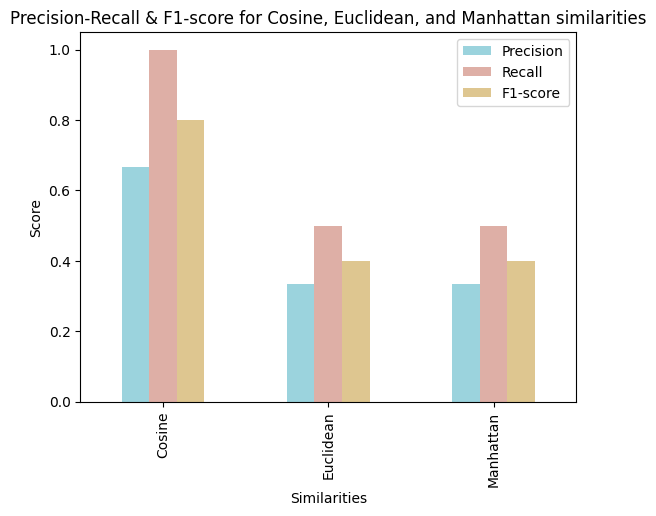

In [139]:
# Define the column names
columns = ['Cosine', 'Euclidean', 'Manhattan']

# Create a bar plot with three colors
colors = ['#9BD3DD', '#DEAFA6', '#DEC690']
ax = comparision.plot(kind='bar', color=colors)

# Customize the plot
ax.set_xlabel('Similarities')
ax.set_ylabel('Score')
ax.set_xticklabels(columns)  # Add x-axis column names
ax.set_title('Precision-Recall & F1-score for Cosine, Euclidean, and Manhattan similarities')

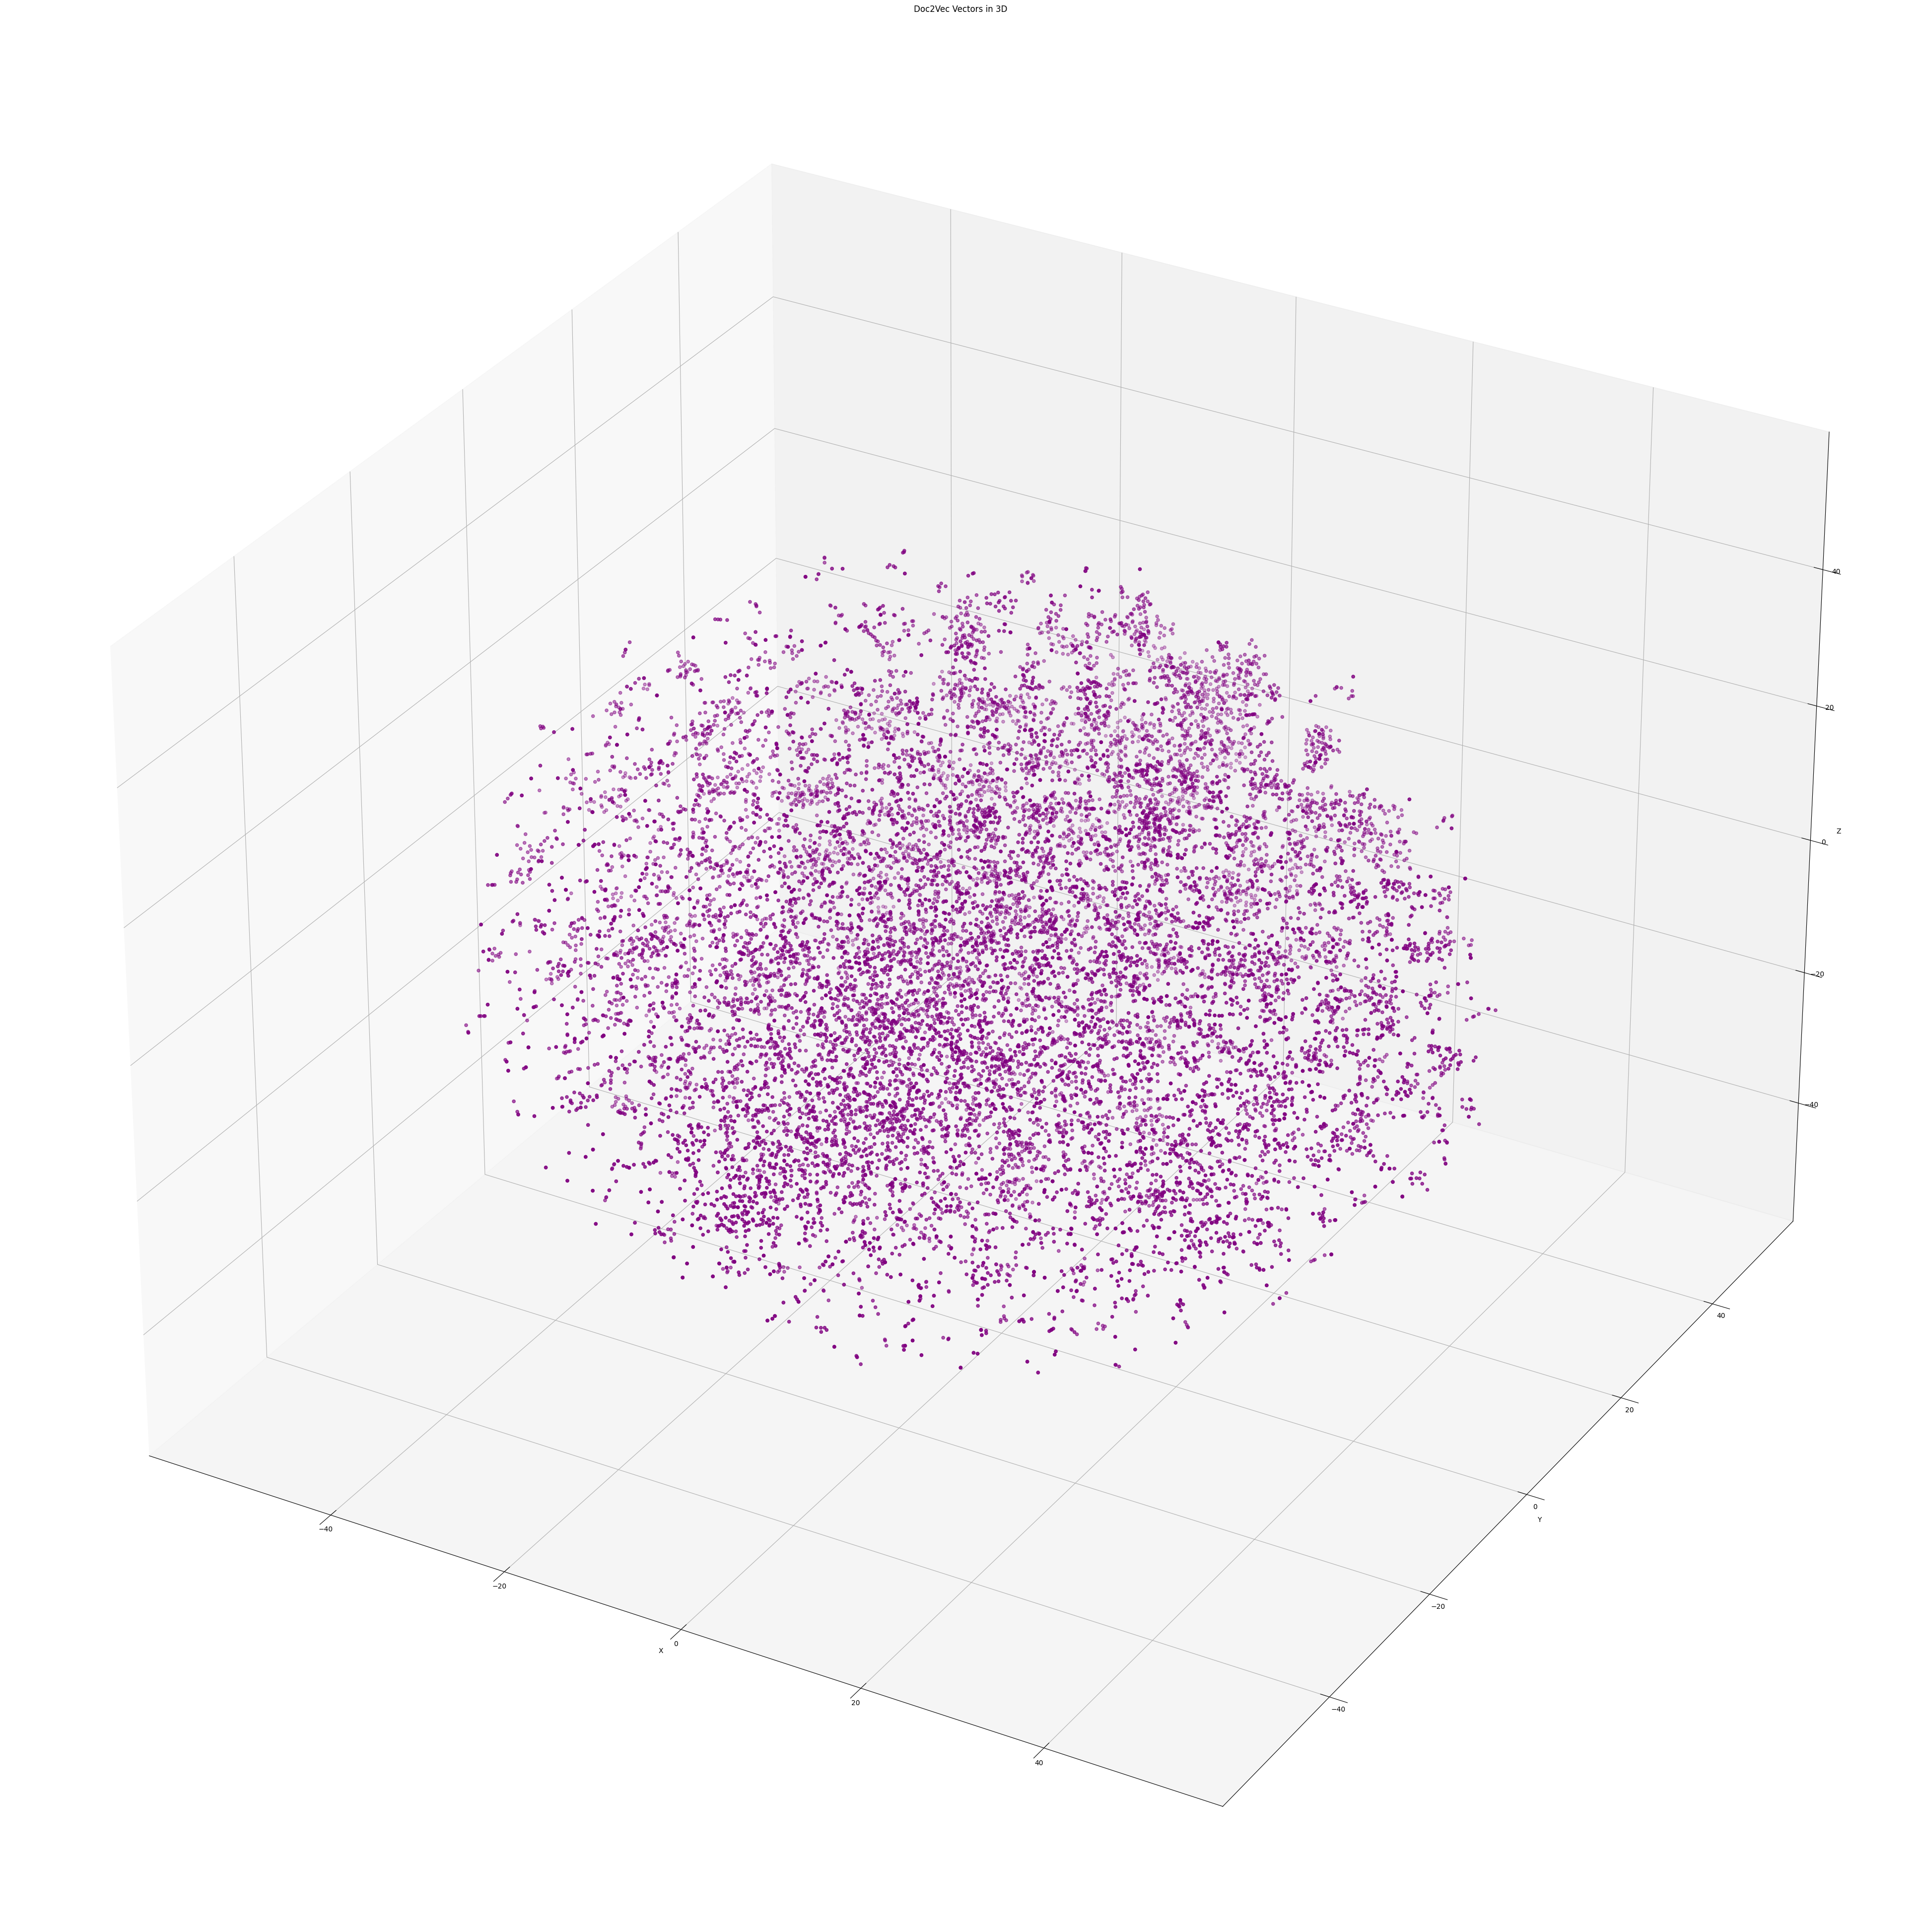

In [140]:
from gensim.models.doc2vec import Doc2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the trained Doc2Vec model
model = Doc2Vec.load('doc2vec.model')

# Get the document vectors
vectors = model.dv.vectors

# Project the vectors to 3D using t-SNE
tsne = TSNE(n_components=3, random_state=0)
projected_vectors = tsne.fit_transform(vectors)

# Create a larger plot and set the color to purple
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projected_vectors[:, 0], projected_vectors[:, 1], projected_vectors[:, 2], color='purple')

# Set the axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Doc2Vec Vectors in 3D')

# Show the plot
plt.show()